# Лабораторная работа №2. Дискриминантный анализ.


### 1. Подготовка библиотек
Импортируем необходимые библиотеки:

In [1]:
import numpy as np # поддерживает матрицы, массивы, мат.функции для них
import pandas as pd # библиотека для анализа данных
from scipy.stats import f
from scipy.spatial.distance import mahalanobis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 2. Преддискриминантный этап анализа
Целью дискриминантного анализа является разделение рассматриваемой совокупности объектов или явлений на заданные обучающими выборками классы. Исходные данные для анализа представлены в виде матрицы.

Есть два способа создания тренировочной выборки - с помощью списка TRAIN_SAMPLES или заполнение вручную стобца в Excel-файле.

In [2]:
_ = \
"""
    Что поменять:
        0) названия файлов, для считывания и для записи(этот в самом конце)
        1) FEATURES
        2) задать TRAIN_SAMPLES, если не задается, то удалить параметр из вызова функции gen_train_data
        3) задать F to enter в sda
"""

In [3]:
# В переменную FEATURES записываем названия показателей
FEATURES = ["x1", "x2", "x3", "x4", "x5"] 

# создаем словарь - для каждого класса перечисляем номера объектов тренировочной выборки в зависимости от варианта

TRAIN_SAMPLES = {
    1 : [1, 2, 3, 4, 6, 8, 24, 29, 43],
    2 : [12, 14, 16, 21, 23, 27, 28, 41],
}


In [4]:
data = pd.read_excel("C:\Games\Ekonometrika\data_for_lab2_part1_1.xlsx") # считываем данные из файла (файл, который содержит ВСЕ строки и ВСЕ признаки)
data.head() #по умолчанию метод head выведет первые 5 строк

,x1,x2,x3,x4,x5,x6
1,9.26,0.78,1.37,0.23,1.45,1.0
2,9.38,0.75,1.49,0.39,1.30,1.0
3,12.11,0.68,1.44,0.43,1.37,1.0
4,10.81,0.70,1.42,0.18,1.65,1.0
5,9.35,0.62,1.35,0.15,1.91,NaN


Создаем новую переменную, в которую будем записывать все данные, которые необходимо включить в итоговый Excel-файл.

In [5]:
data_to_excel = data[FEATURES]

Далее, вводим функцию gen_train_data по созданию тренировочной выборки.
<br>Аргументы функции: 
- data - данные для анализа
- features - названия признаков 
- train_samples - опциональный параметр: если он передан, то разбиение классов обучающей выборкой задается при помощи train_samples (1 часть ЛР), в противном случае разбиение должно присутствовать в одном из столбцов data (2 часть ЛР)

In [6]:
def gen_train_data(data, features, train_samples=None):
    if train_samples: # если опциональный параметр задан
        train_data = pd.DataFrame() # создаем тренировочную выборку, пока пустую
        for cls, samples in train_samples.items(): # в cls записываем номера классов, в samples список объектов этого класса
            train_samps = data[features].loc[samples] # выбираем объекты обучающей выборки
            train_samps["Class"] = cls # добавляем к ним колонку с номером класса
            train_data = pd.concat([train_data, train_samps]) # concat - функция объединения таблиц
    else:
        assert data.shape[1] == len(features) + 1 # если в исходном файле нет доп.колонки с разбиением, выдаст ошибку
        train_data = data.dropna() # берем в тренировочную выборку только те строки, где проставлены классы
        cls_col = train_data.drop(columns=features).columns[0] 
        train_data = train_data.rename({cls_col: "Class"}, axis=1) # переименовываем колонку с обучающей выборкой на  "Class"
    train_data = train_data.astype({"Class": 'int32'}) # присваем колонке "Class" тип int
    return train_data

In [7]:
# если классы заданы в файле - TRAIN_SAMPLES надо удалить
train_data = gen_train_data(data, FEATURES)
train_data.head() # смотрим результаты работы функции gen_train_data

,x1,x2,x3,x4,x5,Class
1,9.26,0.78,1.37,0.23,1.45,1
2,9.38,0.75,1.49,0.39,1.30,1
3,12.11,0.68,1.44,0.43,1.37,1
4,10.81,0.70,1.42,0.18,1.65,1
6,9.87,0.76,1.39,0.34,1.68,1


Добавим столбец с обучающей выборкой в переменную.

In [8]:
data_to_excel["Train sample"] = train_data.Class

Для расчета Лямбды Уилкса необходимо знать: <br>
1) общая матрица рассеяния: 
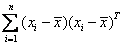

2) внутриклассовые матрицы разброса
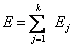

где 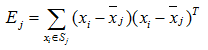

In [9]:
# проведем расчет матрицы рассеяния 

def scatter_matrix(samples):
    if isinstance(samples, pd.Series):
        samples = samples.to_frame()
    d = samples - samples.mean()
    res = np.zeros((d.shape[1], d.shape[1]))
    for _, row in d.iterrows():
        col = row.to_frame()
        res += col @ col.T
    return res

In [10]:
# проведем расчет внутриклассовых матриц разброса

def classes_scatter_matrix(samples, labels):
    A = np.zeros((samples.shape[1], samples.shape[1]))
    for cls in labels.unique():
        A += scatter_matrix(samples[labels == cls])
    return A

Рассчитаем ковариационную матрицу:

In [11]:
# выведем ковариационную матрицу
# она рассчитывается как классовая матрица рассеяния "classes_scatter_matrix", деленная на (кол-во объектов - кол-во классов)

cov = pd.DataFrame(
    classes_scatter_matrix(train_data[FEATURES], train_data.Class) / (train_data.shape[0] - train_data.Class.unique().size), 
    index=FEATURES, 
    columns=FEATURES
)

cov

,x1,x2,x3,x4,x5
x1,0.778698,-0.008771,0.035725,0.002463,-0.092497
x2,-0.008771,0.001339,0.001063,-0.001158,0.005650
x3,0.035725,0.001063,0.009425,0.006585,-0.010273
x4,0.002463,-0.001158,0.006585,0.056295,-0.014133
x5,-0.092497,0.005650,-0.010273,-0.014133,0.163040


Для проведения дискриминантного анализа используем возможности класса LinearDiscriminantAnalysis.

In [12]:
# "обучаем" модель с помощью метода fit класса LinearDiscriminantAnalysis 
# в метод fit передаем исходные данные
lda = LinearDiscriminantAnalysis().fit(train_data[FEATURES], train_data.Class)

Рассчитаем оценки математических ожиданий в классах.

In [13]:
# выведем средние значения параметров для каждого класса обучающей выборки
means = pd.DataFrame(lda.means_, index=lda.classes_, columns=FEATURES)
means

,x1,x2,x3,x4,x5
1,9.928889,0.736667,1.355556,0.274444,1.810
2,6.153750,0.751250,1.282500,0.580000,1.185


### 3.	Дискриминантный анализ

Определим линейные дискриминантные функции Фишера.
Зададим функцию вывода коэффициентов функции Фишера.

In [14]:
def get_df_coef(lda, features, ):
    if lda.classes_.size == 2: #если 2 класса, то lda вернет разность коэффициентов функций
        return pd.DataFrame(
            np.concatenate([lda.intercept_, lda.coef_.ravel()]),
            index=["Intercept"] + features,
            columns=["Discriminant F"]
        )
# если 3 и более классов, то lda вернет несколько функций (аналогично ППП Statistica)
    return pd.DataFrame(
        np.vstack([lda.intercept_, lda.coef_.T]),
        index=["Intercept"] + features,
        columns=lda.classes_
    )

In [15]:
df_coef = get_df_coef(lda, FEATURES) # применим эту функцию для наших параметров
df_coef

,Discriminant F
Intercept,49.694461
x1,-5.890737
x2,-1.567142
x3,5.299984
x4,3.403398
x5,-6.492083


Зададим функцию расчета квадратов расстояний Махаланобиса между классами, где:
 - centers - центры классов
 - samples - объекты, для которых считаем расстояния
 - cov - ковариационная матрицы

In [16]:
def calc_mahalanobis_square_dist(centers, samples, cov):
    # создаем матрицу расстояний между классами и объекnами
    res = pd.DataFrame(index=samples.index, columns=centers.index)
    for i in centers.index: # проходим по всем центрам классов
        for j in samples.index: # проходим по всем объектам
            # считаем расстояние между текущим классом и объектом
            res[i][j] = mahalanobis(centers.loc[i], samples.loc[j], np.linalg.inv(cov)) ** 2 
    return res

In [17]:
# выведем квадраты расстояний Махаланобиса между классами
center_distance = calc_mahalanobis_square_dist(means, means, cov)
center_distance

,1,2
1,0,26.9258
2,26.9258,0


Выведем оценки априорных вероятностей:

In [18]:
lda.priors_ 

array([0.52941176, 0.47058824])

Далее, определим функцию вывода номеров классов для переданных X:

In [19]:
def LDA_predict(lda, X):
    return pd.DataFrame(
        lda.predict(X),
        columns=["Class"],
        index=X.index
    )

Поведем повторную классификацию объектов тренировочной выборки:

In [20]:
lda_predict_train = LDA_predict(lda, train_data[FEATURES])
# сравниваем полученные классы с теми, которые были заданы в начале, и смотрим долю совпадения
(lda_predict_train.Class == train_data.Class).value_counts(normalize=True)

True    1.0
Name: Class, dtype: float64

Получим полную картину классификации всех объектов:

In [21]:
lda_predict = LDA_predict(lda, data[FEATURES])
lda_predict.head()
print(lda_predict)

    Class
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       2
10      2
11      2
12      2
13      2
14      2
15      2
16      2
17      2
18      2
19      2
20      1
21      2
22      2
23      2
24      1
25      1
26      2
27      2
28      2
29      1
30      1
31      2
32      2
33      1
34      2
35      1
36      2
37      1
38      1
39      1
40      1
41      2
42      2
43      1
44      2
45      2
46      2
47      2
48      2
49      2
50      2
51      2
52      1
53      1


Запишем результаты классификации в переменную.

In [22]:
data_to_excel["Results lda"] = lda_predict

Выведем квадраты расстояний Махаланобиса между классами и объектами:

In [23]:
samp_dist = calc_mahalanobis_square_dist(means, data[FEATURES], cov)
samp_dist.head()
print(samp_dist)

           1        2
1    4.45332  19.1095
2    5.15273    16.82
3    7.21173  51.9896
4    3.17193  38.2459
5    28.2178  50.1621
6   0.945794  24.7516
7    6.76182  15.9867
8    2.96927  23.4827
9    32.4264    16.18
10   22.8866  11.8414
11   26.4201  12.8198
12   39.4352  8.05396
13    28.461  17.3415
14   26.0529  1.68146
15   91.3595  35.2878
16   17.9565  2.87948
17   15.0693  3.24838
18   49.9347  42.7859
19   37.6077    31.28
20   4.64434  21.0462
21   20.7057  1.14933
22   12.9011  9.43869
23   54.9972  10.1803
24   2.95269  29.7909
25   24.6087  83.2763
26   22.3056  7.51611
27    35.294  5.32054
28   36.0919  4.93898
29    8.2454  47.9617
30    16.507  18.5604
31   169.131  118.832
32   18.7388  11.3832
33   5.59691  25.4078
34   16.9302  7.86949
35   13.1008  22.4639
36   47.2122  32.3443
37   29.0785  57.0162
38   6.57822  12.4819
39    39.224     90.6
40   17.0233  19.7874
41   21.5438  2.46699
42   26.7366  7.72436
43   3.22611  28.5091
44   21.5616  20.3238
45    40.3

In [24]:
data_to_excel = pd.concat([data_to_excel, samp_dist.add_prefix("lda mahalanobis ")], axis=1)

Зададим функцию для вывода апостериорных вероятностей:

In [25]:
def LDA_predict_proba(lda, X):
    return pd.DataFrame(
        lda.predict_proba(X),
        columns=lda.classes_,
        index=X.index
    )

Применим функцию LDA_predict_proba для наших данных:

In [26]:
lda_post_prob = LDA_predict_proba(lda, data[FEATURES])
lda_post_prob.head()
print(lda_post_prob)

               1             2
1   9.994165e-01  5.834948e-04
2   9.974046e-01  2.595412e-03
3   1.000000e+00  1.680547e-10
4   1.000000e+00  2.150997e-08
5   9.999847e-01  1.526481e-05
6   9.999940e-01  6.018277e-06
7   9.912528e-01  8.747171e-03
8   9.999688e-01  3.121816e-05
9   3.335388e-04  9.996665e-01
10  4.474799e-03  9.955252e-01
11  1.251264e-03  9.987487e-01
12  1.725015e-07  9.999998e-01
13  4.312256e-03  9.956877e-01
14  5.740673e-06  9.999943e-01
15  7.505108e-13  1.000000e+00
16  5.983433e-04  9.994017e-01
17  3.040562e-03  9.969594e-01
18  3.057311e-02  9.694269e-01
19  4.538675e-02  9.546132e-01
20  9.997562e-01  2.438478e-04
21  6.375504e-05  9.999362e-01
22  1.661124e-01  8.338876e-01
23  2.085809e-10  1.000000e+00
24  9.999987e-01  1.321313e-06
25  1.000000e+00  1.619374e-13
26  6.907951e-04  9.993092e-01
27  3.487362e-07  9.999997e-01
28  1.933670e-07  9.999998e-01
29  1.000000e+00  2.111351e-09
30  7.584979e-01  2.415021e-01
31  1.345324e-11  1.000000e+00
32  2.76

In [27]:
data_to_excel = pd.concat([data_to_excel, lda_post_prob.add_prefix("lda post prob ")], axis=1)

### 4.	Пошаговый дискриминантный анализ

Зададим функцию расчета Лямбды Уилкса:

In [28]:
def wilks_lambda(samples, labels):
    if isinstance(samples, pd.Series):
        samples = samples.to_frame()
    dT = np.linalg.det(scatter_matrix(samples)) # расчет определителя матрицы рассеяния
    dE = np.linalg.det(classes_scatter_matrix(samples, labels)) # расчет определителя матрицы классового рассеяния
    return dE / dT # их частное и есть Лямбда Уилкса

Зададим функцию расчета f value и p value :
- lmbda - Лямбда Уилкса
- n_obs - кол-во объектов
- n_var - кол-во признаков
- n_cls - кол-во классов

In [29]:
def f_value_wilks_lambda(lmbda, n_obs, n_var, n_cls):
    num = (1 - lmbda) * (n_obs - n_cls - n_var)
    den = lmbda * (n_cls - 1)
    f_value = num / den #значение статистики Фишера
    # f.sf считает p value для определенного значения статистики Фишера и заданных степеней свободы
    p_value = f.sf(f_value, n_cls - 1, n_obs - n_cls - n_var) 
    return f_value, p_value

sda - функция для проведения пошагового дискриминантного анализа:
 - samples - набор объектов
 - labels - названия классов
 - F_in=1e-4 - установленное нами значение F_to_Enter
Функция выводит для каждого шага переменные в модели(into) и вне модели(out) и их характеристики.

In [30]:
def sda(samples, labels, F_in = 28.25):
    stat_columns = ["Wilk's lambda", "Partial lambda", "F to enter", "p-value"]
    n_cls = labels.unique().size # количество классов
    n_obs = samples.shape[0] # количество объектов
    
    # словари для вывода переменных в модели и вне модели на каждом шаге
    out = {0: pd.DataFrame(columns=stat_columns, index=samples.columns, dtype=float)} 
    into = {0: pd.DataFrame(columns=stat_columns, dtype=float)}
    
    step = 0
    while True:
        model_lambda = wilks_lambda(samples[into[step].index], labels) #посчитали Лямбду Уилкса для модели на данном шаге
        
        for x in out[step].index: # проходим по переменным вне модели на данном шаге
        # далее рассчитываем характеристики для данных переменных и записываем их в таблицу    
            lmbda = wilks_lambda(samples[into[step].index.tolist() + [x]], labels) 
            partial_lambda = lmbda / model_lambda
            f_lambda, p_value = f_value_wilks_lambda(partial_lambda, n_obs, into[step].index.size, n_cls)
            out[step].loc[x] = lmbda, partial_lambda, f_lambda, p_value 
            
        for x in into[step].index: # проходим по переменным в модели на данном шаге
        # далее рассчитываем характеристики для данных переменных и записываем их в таблицу  
            lmbda = wilks_lambda(samples[into[step].index.drop(x)], labels)
            partial_lambda = model_lambda / lmbda
            f_lambda, p_value = f_value_wilks_lambda(partial_lambda, n_obs, into[step].index.size - 1, n_cls)
            into[step].loc[x] = lmbda, partial_lambda, f_lambda, p_value
            
        # критерий для остановки цикла 
        # если вне модели нет переменных ИЛИ новая переменная обладает f_to_enter меньше порогового значения, цикл остановлен
        if out[step].index.size == 0 or out[step]["F to enter"].max() < F_in:
            break
        
        # ищем элемент с max f_to_enter
        x_to_enter = out[step]["F to enter"].idxmax()
        # переносим его из элементов "вне модели" в элементы "в модели"
        into[step + 1] = into[step].append(out[step].loc[x_to_enter])
        out[step + 1] = out[step].drop(index=x_to_enter)
        
        step += 1 # переходим к следующему шагу
        
    return into, out 

Вызываем результаты работы заданной выше функции:

In [31]:
into, out = sda(train_data[FEATURES], train_data.Class, 2.2)

Выводим результаты работы для переменных "в модели" на экран:

In [32]:
for i, t in into.items():
    print("Step ", i)
    print(t, end="\n\n")

Step  0
Empty DataFrame
Columns: [Wilk's lambda, Partial lambda, F to enter, p-value]
Index: []

Step  1
    Wilk's lambda  Partial lambda  F to enter       p-value
x1            1.0        0.162138      77.514  2.596437e-07

Step  2
    Wilk's lambda  Partial lambda  F to enter   p-value
x1       0.596486        0.201810   55.372153  0.000003
x5       0.162138        0.742437    4.856828  0.044778



Выводим результаты работы для переменных "вне модели" на экран:

In [33]:
for i, t in out.items():
    print("Step ", i)
    print(t, end="\n\n")

Step  0
    Wilk's lambda  Partial lambda  F to enter       p-value
x1       0.162138        0.162138   77.514000  2.596437e-07
x2       0.957084        0.957084    0.672609  4.249847e-01
x3       0.862149        0.862149    2.398376  1.422985e-01
x4       0.681070        0.681070    7.024179  1.817985e-02
x5       0.596486        0.596486   10.147275  6.143791e-03

Step  1
    Wilk's lambda  Partial lambda  F to enter   p-value
x2       0.157597        0.971994    0.403387  0.535588
x3       0.153109        0.944317    0.825523  0.378946
x4       0.149852        0.924226    1.147816  0.302129
x5       0.120377        0.742437    4.856828  0.044778

Step  2
    Wilk's lambda  Partial lambda  F to enter   p-value
x2       0.120299        0.999350    0.008460  0.928119
x3       0.118606        0.985290    0.194079  0.666780
x4       0.116889        0.971027    0.387885  0.544184



Выводим названия признаков в модели:

In [34]:
stepwise_features = into[len(into) - 1].index.tolist()
stepwise_features

['x1', 'x5']

Проводим дискриминантный анализ для отобранных признаков.

In [35]:
stepwise_lda = LinearDiscriminantAnalysis().fit(train_data[stepwise_features], train_data.Class)

 Выводим коэффициенты функции Фишера на экран.

In [36]:
stepwise_df_coef = get_df_coef(stepwise_lda, stepwise_features)
stepwise_df_coef

,Discriminant F
Intercept,56.181422
x1,-5.686571
x5,-7.059549


Пполучим полную картину классификации всех объектов.

In [37]:
stepwise_lda_predict = LDA_predict(stepwise_lda, data[stepwise_features])
stepwise_lda_predict.head()
print(stepwise_lda_predict)

    Class
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       2
10      2
11      2
12      2
13      2
14      2
15      2
16      2
17      2
18      1
19      1
20      1
21      2
22      1
23      2
24      1
25      1
26      2
27      2
28      2
29      1
30      1
31      2
32      2
33      1
34      2
35      1
36      2
37      1
38      1
39      1
40      1
41      2
42      2
43      1
44      2
45      2
46      2
47      2
48      2
49      2
50      2
51      2
52      1
53      1


Запишем результаты классификации в переменную.

In [38]:
data_to_excel["Results stepwise lda"] = stepwise_lda_predict

In [39]:
stepwise_cov = classes_scatter_matrix(train_data[stepwise_features], train_data.Class) \
    / (train_data.shape[0] - train_data.Class.unique().size)

stepwise_means = pd.DataFrame(stepwise_lda.means_, index=stepwise_lda.classes_, columns=stepwise_features)

stepwise_samp_dist = calc_mahalanobis_square_dist(stepwise_means, data[stepwise_features], stepwise_cov)
stepwise_samp_dist.head()
print(stepwise_samp_dist)

           1         2
1    1.84464   15.0342
2    2.56281   14.9993
3    6.32449    50.798
4    1.01713   34.6589
5   0.436767   21.1447
6   0.127882   23.5025
7    4.01387   11.7251
8   0.841951   18.6517
9    21.8624   3.52913
10   17.1269   5.26464
11   18.2204   4.03637
12   36.7152  0.956813
13   15.9859    3.4332
14   25.6782  0.681015
15   63.0611    8.3485
16   15.3043   1.91576
17    12.896   2.72761
18   5.13135   7.96357
19   6.60247   6.46189
20   2.34349   20.2633
21   18.9915  0.547995
22   6.26496   6.68525
23    42.948    2.7303
24    1.5813   28.0231
25   13.5101   70.0391
26   16.7435   1.32379
27   28.3311  0.522468
28   30.4599   2.92606
29   4.44168   42.7942
30   4.49805   9.41289
31   55.1356   7.27112
32   15.2813   8.14884
33   3.37016   24.6148
34    9.3689   4.10652
35   3.69723    10.608
36   15.7446   1.25415
37   3.67348   32.6754
38   4.83917   11.2046
39   16.2824   67.1441
40   4.96097    12.899
41   19.3684  0.477713
42   16.7379   1.26331
43  0.49998

In [40]:
data_to_excel = pd.concat([data_to_excel, stepwise_samp_dist.add_prefix("stepwise lda mahalanobis ")], axis=1)

In [41]:
stepwise_lda_post_prob = LDA_predict_proba(stepwise_lda, data[stepwise_features])
stepwise_lda_post_prob.head()
print(stepwise_lda_post_prob)

               1             2
1   9.987859e-01  1.214063e-03
2   9.982318e-01  1.768199e-03
3   1.000000e+00  1.956820e-10
4   1.000000e+00  4.401823e-08
5   9.999717e-01  2.832461e-05
6   9.999925e-01  7.466536e-06
7   9.815376e-01  1.846239e-02
8   9.998794e-01  1.206315e-04
9   1.175109e-04  9.998825e-01
10  2.978487e-03  9.970215e-01
11  9.348050e-04  9.990652e-01
12  1.933382e-08  1.000000e+00
13  2.110857e-03  9.978891e-01
14  4.198465e-06  9.999958e-01
15  1.480593e-12  1.000000e+00
16  1.390794e-03  9.986092e-01
17  6.919842e-03  9.930802e-01
18  8.225755e-01  1.774245e-01
19  5.118719e-01  4.881281e-01
20  9.998858e-01  1.141741e-04
21  1.112089e-04  9.998888e-01
22  5.812561e-01  4.187439e-01
23  2.079664e-09  1.000000e+00
24  9.999984e-01  1.610915e-06
25  1.000000e+00  4.717652e-13
26  5.041777e-04  9.994958e-01
27  1.029387e-06  9.999990e-01
28  1.181004e-06  9.999988e-01
29  1.000000e+00  4.175493e-09
30  9.292486e-01  7.075137e-02
31  4.544676e-11  1.000000e+00
32  3.08

In [42]:
data_to_excel = pd.concat([data_to_excel, stepwise_lda_post_prob.add_prefix("stepwise lda post prob ")], axis=1)
data_to_excel.head()

,x1,x2,x3,x4,x5,Train sample,Results lda,lda mahalanobis 1,lda mahalanobis 2,lda post prob 1,lda post prob 2,Results stepwise lda,stepwise lda mahalanobis 1,stepwise lda mahalanobis 2,stepwise lda post prob 1,stepwise lda post prob 2
1,9.26,0.78,1.37,0.23,1.45,1.0,1,4.45332,19.1095,0.999417,5.834948e-04,1,1.84464,15.0342,0.998786,1.214063e-03
2,9.38,0.75,1.49,0.39,1.30,1.0,1,5.15273,16.82,0.997405,2.595412e-03,1,2.56281,14.9993,0.998232,1.768199e-03
3,12.11,0.68,1.44,0.43,1.37,1.0,1,7.21173,51.9896,1.000000,1.680547e-10,1,6.32449,50.798,1.000000,1.956820e-10
4,10.81,0.70,1.42,0.18,1.65,1.0,1,3.17193,38.2459,1.000000,2.150997e-08,1,1.01713,34.6589,1.000000,4.401823e-08
5,9.35,0.62,1.35,0.15,1.91,NaN,1,28.2178,50.1621,0.999985,1.526481e-05,1,0.436767,21.1447,0.999972,2.832461e-05


Записываем результаты проведенной работы в файл.

In [43]:
data_to_excel.to_excel("C:\Games\Ekonometrika\data_for_lab2_part1_2.xlsx")